### Earthquake Since 1900 - GIS Programming and Web Scraping with Python

Author: Tingting Duan (Github: https://github.com/Tingting0618)
<br> June 25, 2021

### Goal/inspiration
Nate Silver discusses the difficulty of predicting earthquakes in **The Signal and the Noise**. Nevertheless, we will try to identify some patterns by analyzing the deadly earthquakes that have occurred since 1900.

To start, we read the table of earthquakes from https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900 using the `requests` and/or `beautifulsoup` library and load it to a pandas dataframe.

Data cleaning tasks include:

* Replaced empty strings with NaN
* Removed the footnotes from the 'Other Source Deaths' column
* Converted Magnitude to a numeric type.
* Corrected number of deaths when there is more than one value. When there is more than one value given, we chose the largest.
* Created a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
* Explored the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

In [1]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from shapely.geometry import Point
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import os
from IPython.core.display import HTML

if not os.path.exists("images"):
    os.mkdir("images")

### Get worldwide earthquake data table from Wiki

In [2]:
def get_data(url,att_class):
    response = requests.get(url)
    soup = BS(response.text, 'html.parser')
    table_html = str(soup.find('table', attrs={'class' : att_class}))
    # from IPython.core.display import HTML
    # HTML(table_html)
    tables = pd.read_html(table_html,header = 0)
    turing_table = tables[0]
    turing_table.to_csv('data/raw_data.csv',index = False)

In [3]:
url='https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
att_class="sortable wikitable"
get_data(url,att_class)

In [4]:
def get_mag(mag):
    try:
        return float(re.sub('\s[a-zA-Z]+',"",mag))
    except:
        return None

In [5]:
def get_max_death(row):
    try:
        value = re.sub('\[\d*\]',"",row)
        value = re.sub('\+',"",value)
        value = re.sub('\s\(.*',"",value)
        value = re.sub('\*',"",value)
        value = value.replace(',', '')
        value = max([int(i) for i in value.split(' ')])
        return value
    except:
        return None

In [6]:
def get_country(row):
    try:
        return re.sub('\s\(.*',"",row)
    except:
        return None

In [7]:
def clean_data():
    data=pd.read_csv('data/raw_data.csv',parse_dates=["Origin (UTC)"])
    data=data.rename(columns={"Origin (UTC)": "time", "Present-day country and link to Wikipedia article": "country","Depth (km)": "depth_km","Secondary Effects":"secondary_effects","PDE Shaking Deaths":"pde_shaking_deaths","PDE Total Deaths":"pde_total_deaths","Utsu Total Deaths":"utsu_total_deaths","EM-DAT Total Deaths":"emdat_total_deaths","Other Source Deaths":"other_source_deaths","Lat":"lat","Long":"long","Magnitude":"magnitude"})
    data["magnitude_clean"] = [get_mag(row) for row in data.magnitude]
    data["emdat_total_deaths_max"] = [get_max_death(row) for row in data.emdat_total_deaths]
    data["other_source_deaths_max"] = [get_max_death(row) for row in data.other_source_deaths]
    data['deaths'] = data[['pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths_max','other_source_deaths_max']].max(axis=1)
    data['country_clean'] = [get_country(row) for row in data.country]
    data['country_clean'].replace({'(see 1997 Cariaco earthquake)': 'Venezuela', 'Saudi Arabia/Egypt': 'Saudi Arabia', 'Mandatory Palestine and Transjordan': 'British Mandate for Palestine', 'Iran, 2005 Qeshm earthquake': 'Iran','US Territory of Alaska': 'United States','United States Minor Outlying Islands':'United States','Russian Federation':'Russia'},inplace= True)
    data['yr'] = data['time'].apply(lambda x: x.strftime('%Y')) 
    return data

In [8]:
data = clean_data()
data.to_csv('data/clean_data.csv',index=False)

In [9]:
data.head(3)

,time,country,lat,long,depth_km,magnitude,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,emdat_total_deaths,other_source_deaths,magnitude_clean,emdat_total_deaths_max,other_source_deaths_max,deaths,country_clean,yr
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,Japan,1900
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN,5.9,NaN,NaN,140.0,Turkey,1900
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,7.7,NaN,NaN,NaN,Venezuela,1900


### Map earthquake data by location and year

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data_sum = data.groupby(by='country_clean')['deaths'].sum()
data_sum = data_sum.reset_index()
data_shp_sum = pd.merge(world,data_sum, how = 'left',left_on ="name" ,right_on="country_clean")
data_shp_sum=data_shp_sum.fillna(0)

In [11]:
@interact(year = widgets.IntSlider(value = 1900, min =1900, max = 2018))

def make_plot(year):
    import plotly.graph_objects as go
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    data_sum = data.loc[data.yr== str(year)].groupby(by= 'country_clean')['deaths'].sum()
    data_sum = data_sum.reset_index()
    data_shp_sum = pd.merge(world,data_sum, how = 'left',left_on ="name" ,right_on="country_clean")
    data_shp_sum=data_shp_sum.fillna(0)
    
    fig = go.Figure(data=go.Choropleth(
        locationmode="country names",
        locations = data_shp_sum['name'],
        z = data_shp_sum['deaths'],
        text = data_shp_sum['name'],
        colorscale = 'Blues',
        zmax = 5000,
        zmin = -1000,
        autocolorscale=False,
        reversescale=False,
        marker_line_color='white',
        marker_line_width=0.5,
    #     colorbar_tickprefix = '$',
        colorbar_title = 'Number of Deaths Per Country ',
    ))

    fig.update_layout(
        title_text='1900-2018 Number of Earthquake Deaths Per Country',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        ),
        annotations = [dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text='Source: <a href="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900">Wikipedia</a>',
            showarrow = False
        )]
    )
    fig.show()

interactive(children=(IntSlider(value=1900, description='year', max=2018, min=1900), Output()), _dom_classes=(…

### Tenessee Earthquake Observations

#### To start, we used the `requests` library and the USGS's API (https://earthquake.usgs.gov/fdsnws/event/1/) to retrieve information about all recorded earthquakes that occurred in Tennessee since 1900.

In [12]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

In [13]:
payload = {'format': 'csv', 
           'starttime': '1900-01-01',
           'minlatitude':'34.9884', 
           'maxlatitude':'36.6871', 
           'minlongitude':'-90.3131', 
           'maxlongitude':'-81.6518', 
           'starttime' : '1900-01-01', 
           'limit':[1,20000]}

In [14]:
r = requests.get(url=url, params=payload)

In [15]:
print(r.url)

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=1900-01-01&minlatitude=34.9884&maxlatitude=36.6871&minlongitude=-90.3131&maxlongitude=-81.6518&limit=1&limit=20000


In [16]:
from io import StringIO
eq = pd.read_csv(StringIO(r.text))
eq.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-06-23T19:04:15.490Z,35.808000,-90.130667,8.57,1.54,md,14.0,105.0,0.02738,0.06,...,2021-06-23T20:57:04.930Z,"8 km SSE of Manila, Arkansas",earthquake,0.35,0.70,0.094,9.0,reviewed,nm,nm
1,2021-06-23T08:54:04.480Z,36.485667,-89.544000,8.71,1.89,md,32.0,45.0,0.05325,0.07,...,2021-06-23T12:11:36.880Z,"7 km ESE of Marston, Missouri",earthquake,0.29,0.65,0.173,27.0,reviewed,nm,nm
2,2021-06-22T09:43:37.270Z,36.495333,-89.548000,7.23,1.38,md,16.0,90.0,0.07877,0.04,...,2021-06-22T18:25:03.260Z,"6 km ESE of Marston, Missouri",earthquake,0.54,0.90,0.068,10.0,reviewed,nm,nm


In [17]:
eq.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

#### Then, we downloaded the US County Boundaries.geojson from (https://public.opendatasoft.com/explore/dataset/us-county-boundaries/download/?format=geojson&timezone=America/Chicago&lang=en).

In [18]:
zipcodes = gpd.read_file('data/us-county-boundaries.geojson')
print(zipcodes.crs)

epsg:4326


In [19]:
zipcodes =zipcodes[zipcodes['stusab']=='TN']

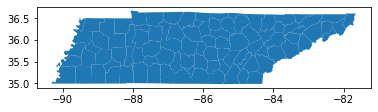

In [20]:
zipcodes.plot();

In [21]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Lastly, we spatial joined the earthquake's lat/long with the geojson file.

In [22]:
eq['geometry'] = eq.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis = 1)

In [23]:
eq.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry
0,2021-06-23T19:04:15.490Z,35.808000,-90.130667,8.57,1.54,md,14.0,105.0,0.02738,0.06,...,"8 km SSE of Manila, Arkansas",earthquake,0.35,0.70,0.094,9.0,reviewed,nm,nm,POINT (-90.13066670000001 35.808)
1,2021-06-23T08:54:04.480Z,36.485667,-89.544000,8.71,1.89,md,32.0,45.0,0.05325,0.07,...,"7 km ESE of Marston, Missouri",earthquake,0.29,0.65,0.173,27.0,reviewed,nm,nm,POINT (-89.544 36.4856667)


In [24]:
eq_geo = gpd.GeoDataFrame(eq, crs = zipcodes.crs, geometry = eq['geometry'])

In [25]:
eq_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
type(eq_geo)

geopandas.geodataframe.GeoDataFrame

In [27]:
zipcodes = zipcodes[['namelsad', 'geometry']]
type(zipcodes)

geopandas.geodataframe.GeoDataFrame

In [28]:
eq_by_zip = gpd.sjoin(eq_geo, zipcodes)

In [29]:
eq_by_zip.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry,index_right,namelsad
5,2021-06-18T18:27:14.760Z,36.385667,-89.4995,7.81,0.91,md,10.0,163.0,0.03761,0.07,...,0.33,0.49,0.065,6.0,reviewed,nm,nm,POINT (-89.49950 36.38567),2006,Lake County
10,2021-06-16T08:01:21.570Z,36.322333,-89.5355,9.81,2.01,md,33.0,26.0,0.02528,0.11,...,0.17,0.34,0.083,30.0,reviewed,nm,nm,POINT (-89.53550 36.32233),2006,Lake County


In [30]:
eq_by_zip['depth']=pd.to_numeric(eq_by_zip.depth)

In [31]:
eq_by_zip['namelsad'].value_counts()

Lake County          2199
Dyer County           660
Obion County          402
Monroe County         218
Blount County         146
                     ... 
Fentress County         1
Williamson County       1
Coffee County           1
White County            1
Hardeman County         1
Name: namelsad, Length: 67, dtype: int64

#### This chart maps all earthquake in TN since 1900.

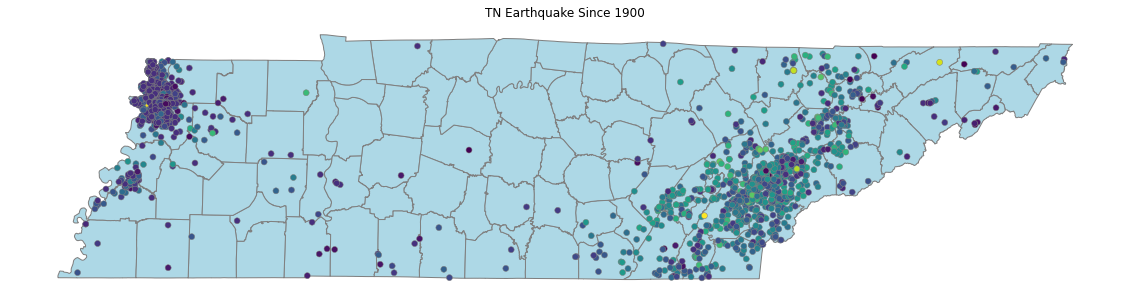

In [32]:
ax = zipcodes.plot(figsize=(20, 16), color = 'lightblue',edgecolor='gray')
eq_by_zip.plot(ax = ax, column = 'depth',linewidth=0.5,edgecolor='gray')
ax.set_title('TN Earthquake Since 1900')
plt.axis('off')
plt.show();

#### Some earthquakes are more severe than others.

In [33]:
eq_by_zip_mag=eq_by_zip.loc[eq_by_zip['mag']>3]

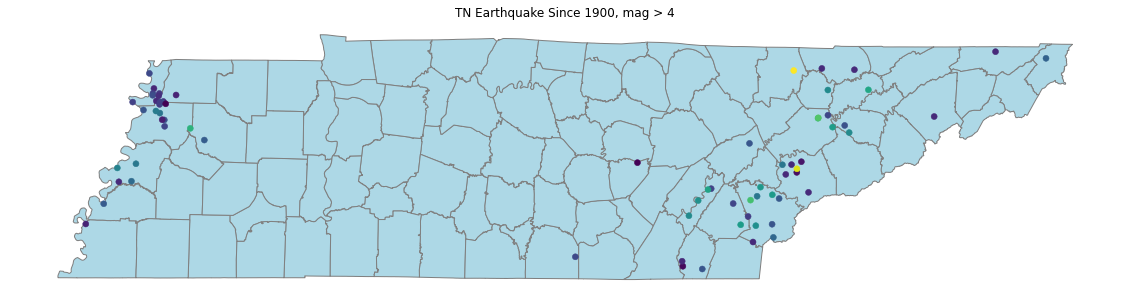

In [34]:
ax = zipcodes.plot(figsize=(20, 16), color = 'lightblue',edgecolor='gray')
eq_by_zip_mag.plot(ax = ax, column = 'depth',linewidth=0.5)
ax.set_title('TN Earthquake Since 1900, mag > 4')
plt.axis('off')
plt.show();

In [35]:
avg = eq_by_zip.groupby('namelsad').mean().reset_index().sort_values('mag',ascending = False)
avg.head(2)

,namelsad,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,index_right
17,Franklin County,35.141250,-85.887417,7.455000,2.955,18.5,69.0,0.08312,0.20,0.4,0.85,0.0820,14.5,242
34,Johnson County,36.504222,-81.771944,8.633333,2.900,29.0,71.5,NaN,0.39,1.1,1.95,0.3005,3.0,231


In [36]:
avg = eq_by_zip.groupby('namelsad').count().reset_index().sort_values('mag',ascending = False)
avg[['namelsad','status']].head(10)

,namelsad,status
36,Lake County,2199
14,Dyer County,660
47,Obion County,402
44,Monroe County,218
3,Blount County,146
40,Loudon County,104
42,McMinn County,94
35,Knox County,62
37,Lauderdale County,40
4,Bradley County,39


#### But most importantly, some earthquakes are more deadly than others.

In [37]:
eq_by_zip_depth=eq_by_zip.loc[eq_by_zip['depth']>15]

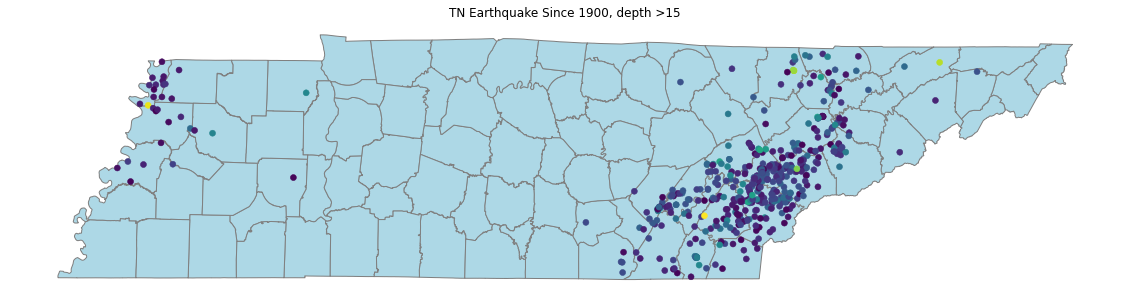

In [38]:
ax = zipcodes.plot(figsize=(20, 16), color = 'lightblue',edgecolor='gray')
eq_by_zip_depth.plot(ax = ax, column = 'depth',linewidth=0.5)
ax.set_title('TN Earthquake Since 1900, depth >15')
plt.axis('off')
plt.show();

#### Based on the findings, we would like to recommend the Tennessee Earthquake Preparedness Group concentrate more resources in the two major metropolitan areas (Knoxville, Chattanooga), and Lake and Dyer Counties.